In [ ]:
import numpy as np
import torch.nn as nn
import random
import torch
import os
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error

In [ ]:
def generate_2(y_no, n_no, min_pow, max_pow):
  result = []
  # num of ab
  for i in range(y_no):
    r = random.randint(min_pow//2, max_pow//2)
    s = "a" * r + "b" * r
    result.append([s, '1'])

  for i in range(n_no):
    r_t = random.randint(min_pow, max_pow)
    r_1 = random.randint(0, r_t)
    r_2 = r_t - r_1
    while r_1 == r_2:
      r_t = random.randint(min_pow, max_pow)
      r_1 = random.randint(0, r_t)
      r_2 = r_t - r_1

    s = "a" * r_1 + "b" * r_2
    result.append([s, '0'])

  return result

def generate_3(y_no, n_no, min_pow, max_pow):
  result = []
  # num of ab
  for i in range(y_no):
    r = random.randint(min_pow//3, max_pow//3)
    s = "a" * r + "b" * r + "c" * r
    result.append([s, '1'])

  for i in range(n_no):
    r_t = random.randint(min_pow, max_pow)
    r_1 = random.randint(0, r_t)
    r_2 = random.randint(0, r_t-r_1)
    r_3 = r_t-r_1-r_2
    while r_1 == r_2 and r_1 == r_3:
      r_t = random.randint(min_pow, max_pow)
      r_1 = random.randint(0, r_t)
      r_2 = random.randint(0, r_t-r_1)
      r_3 = r_t-r_1-r_2

    s = "a" * r_1 + "b" * r_2 + "c" * r_3
    result.append([s, '0'])

  return result

In [ ]:
train_data_abc = generate_3(600, 600, 3, 20)
train_data_abc = np.array(train_data_abc)

train_tensor_abc_x = list(map(lambda s: torch.from_numpy(np.array([0]*s.count('a')+[1]*s.count('b')+[2]*s.count('c')).astype(np.int32)), train_data_abc[:,0]))
train_tensor_abc_y = list(map(lambda s: torch.from_numpy(np.array([s]).astype(np.int32)), train_data_abc[:,1]))

from sklearn.model_selection import train_test_split
train_abc_x, val_abc_x, train_abc_y, val_abc_y = train_test_split(train_tensor_abc_x, train_tensor_abc_y, test_size=0.2)

## Preprocessing

In [ ]:
loss_function=nn.NLLLoss()
all_losses = []
plot_every = 1
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y in zip(train_abc_x, train_abc_y):
            x = x.long()
            y = y.long()
            model.zero_grad()
            model.hidden = model.init_hidden()
            y_pred = model(x)
            # optimizer.zero_grad()
            # print(y_pred)
            # print(y_pred.size())
            loss = loss_function(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model)
        # if i % 5 == 1:
        if i % plot_every == 0:
          all_losses.append(val_loss)
        print("traninig loss %.3f, validation loss %.3f, accuracy %.3f %.3f" % (sum_loss/total, val_loss, val_acc))

def validation_metrics (model):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y in zip(val_abc_x, val_abc_y):
        x = x.long()
        y = y.long()
        model.zero_grad()
        model.hidden = model.init_hidden()
        y_hat = model(x)
        loss = loss_function(y_hat, y)
        ttt = torch.max(y_hat, 1)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [ ]:
class LSTMTagger(torch.nn.Module):
    def __init__(self,embedding_dim,hidden_dim,voacb_size,target_size):
        super(LSTMTagger,self).__init__()
        self.embedding_dim=embedding_dim
        self.hidden_dim=hidden_dim
        self.voacb_size=voacb_size
        self.target_size=target_size
        self.embedding=nn.Embedding(self.voacb_size,self.embedding_dim)
        self.lstm=nn.LSTM(self.embedding_dim,self.hidden_dim)
        self.out2tag=nn.Linear(self.hidden_dim,self.target_size)

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self,inputs):
        embeds=self.embedding((inputs))
        t = embeds.view(len(inputs),1,-1)
        out,(ht, ct)=self.lstm(t,self.hidden)
        tag_space=self.out2tag(ht.view(-1, self.hidden_dim))
        tags=F.log_softmax(tag_space,dim=1)
        return tags

In [ ]:
model_LSTMTagger = LSTMTagger(2, 128, 3, 2)
train_model(model_LSTMTagger, epochs=30, lr=0.0005)

train loss 0.458, val loss 0.268, val accuracy 0.921, and val rmse 0.079
train loss 0.208, val loss 0.165, val accuracy 0.942, and val rmse 0.058
train loss 0.146, val loss 0.136, val accuracy 0.967, and val rmse 0.033
train loss 0.168, val loss 0.147, val accuracy 0.954, and val rmse 0.046
train loss 0.128, val loss 0.090, val accuracy 0.975, and val rmse 0.025
train loss 0.088, val loss 0.097, val accuracy 0.971, and val rmse 0.029
train loss 0.076, val loss 0.068, val accuracy 0.979, and val rmse 0.021
train loss 0.067, val loss 0.061, val accuracy 0.983, and val rmse 0.017
train loss 0.056, val loss 0.055, val accuracy 0.988, and val rmse 0.013
train loss 0.053, val loss 0.046, val accuracy 0.988, and val rmse 0.013
train loss 0.045, val loss 0.069, val accuracy 0.983, and val rmse 0.017
train loss 0.036, val loss 0.013, val accuracy 0.988, and val rmse 0.013
train loss 0.027, val loss 0.011, val accuracy 0.992, and val rmse 0.008
train loss 0.014, val loss 0.027, val accuracy 0.99

## Evaluation

In [ ]:
def evaluate_LSTM(str):
    model_LSTMTagger.hidden = model_LSTMTagger.init_hidden()
    output = model_LSTMTagger(str)
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return category_i

In [ ]:
test_data_abc = generate_3(600, 600, 21, 50)
test_data_abc = np.array(test_data_abc)

test_tensor_abc_x = list(map(lambda s: torch.from_numpy(np.array([0]*s.count('a')+[1]*s.count('b')+[2]*s.count('c')).astype(np.int32)), test_data_abc[:, 0]))

In [ ]:
i, j = 30, 4
preds = [[0 for x in range(j)] for y in range(i)] 

for index, (x, label) in enumerate(zip(test_tensor_abc_x, test_data_abc[:, 1])):
  model_LSTMTagger.hidden = model_LSTMTagger.init_hidden()
  output = model_LSTMTagger(x)
  top_n, top_i = output.topk(1)
  pred = top_i[0].item()
  i = len(test_data_abc[index][0])

  if pred == 1 and label == '1':
    preds[i-21][0] += 1
  elif pred == 1 and label == '0':
    preds[i-21][1] += 1
  elif pred == 0 and label == '1':
    preds[i-21][2] += 1
  elif pred == 0 and label == '0':
    preds[i-21][3] += 1

In [ ]:
accuracy_lstm_abc = []
for pred in preds:
  accuracy_lstm_abc.append((pred[0] + pred[3]) / sum(pred))

In [ ]:
import csv

def write_to_csv(name, accuracy):
  # opening the csv file in 'w+' mode
  file = open(name, 'w+', newline ='')
  
  # writing the data into the file
  with file:   
    write = csv.writer(file)
    write.writerows([accuracy])

def read_to_csv(name):
  result = []
  with open(name, newline='') as inputfile:
      for row in csv.reader(inputfile):
        result.append(row)

  result = result[0]
  result = [float(x) for x in result]
  return result

In [ ]:
write_to_csv('accuracy_lstm_abc.csv', accuracy_lstm_abc)
write_to_csv('loss_lstm_abc.csv', all_losses)

In [ ]:
accuracy_lstm_ab = read_to_csv('accuracy_lstm_ab.csv')
accuracy_lstm_abc = read_to_csv('accuracy_lstm_abc.csv')
accuracy_rnn_ab = read_to_csv('accuracy_rnn_ab.csv')
accuracy_rnn_abc = read_to_csv('accuracy_rnn_abc.csv')

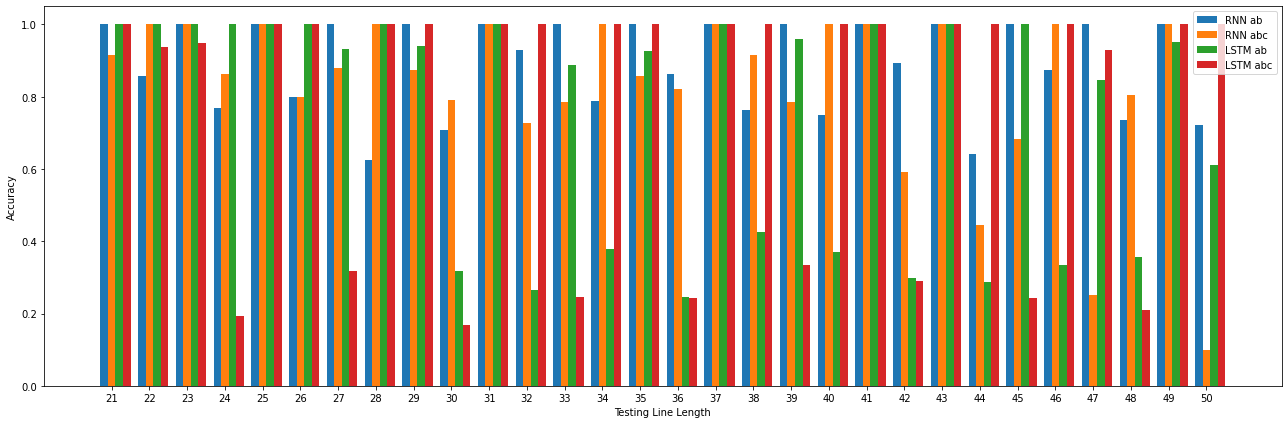

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# data to plot
n_groups = 30

# create plot
fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
index = np.arange(n_groups)
bar_width = 0.2
opacity = 1

rects1 = plt.bar(index, accuracy_rnn_ab, bar_width,
alpha=opacity,
label='RNN ab')

rects2 = plt.bar(index + bar_width, accuracy_rnn_abc, bar_width,
alpha=opacity,
label='RNN abc')

rects3 = plt.bar(index + 2 * bar_width, accuracy_lstm_ab, bar_width,
alpha=opacity,
label='LSTM ab')

rects4 = plt.bar(index + 3 * bar_width, accuracy_lstm_abc, bar_width,
alpha=opacity,
label='LSTM abc')

plt.xlabel('Testing Line Length')
plt.ylabel('Accuracy')
plt.xticks(index + bar_width, np.arange(21, 51))
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
loss_lstm_ab = read_to_csv('loss_lstm_ab.csv')
loss_lstm_abc = read_to_csv('loss_lstm_abc.csv')
loss_rnn_ab = read_to_csv('loss_rnn_ab.csv')
loss_rnn_abc = read_to_csv('loss_rnn_abc.csv')

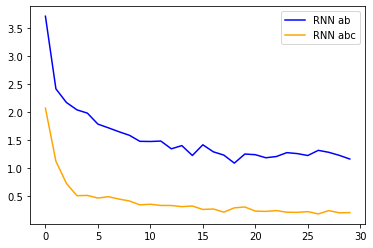

In [ ]:
plt.figure()
plt.plot(loss_rnn_ab, label='RNN ab', color='blue')
plt.plot(loss_rnn_abc, label='RNN abc', color='orange')
plt.legend()

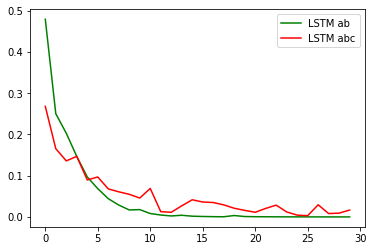

In [ ]:
plt.figure()
plt.plot(loss_lstm_ab, label='LSTM ab', color='green')
plt.plot(loss_lstm_abc, label='LSTM abc', color='red')
plt.legend()